# PHÂN LOẠI XOÀI CHUA/NGỌT BẰNG PHƯƠNG PHÁP NGƯỠNG

---

## 1. GIỚI THIỆU

### 1.1. Giới thiệu bài toán
**Mục tiêu**: Phân loại xoài chua/ngọt dựa vào màu sắc vỏ xoài bằng phương pháp ngưỡng (threshold-based classification).

**Ý tưởng**: 
- Xoài **ngọt** (chín) thường có màu vàng cam → tỷ lệ màu xanh lá thấp
- Xoài **chua** (xanh) thường có màu xanh lá → tỷ lệ màu xanh lá cao

**Đặc trưng sử dụng**:

$$ratio\_green = \frac{\sum G}{\sum R + \sum G + \sum B}$$

Trong đó $\sum R, \sum G, \sum B$ là tổng các giá trị kênh màu trên vùng xoài (sau khi tách nền).

### 1.2. Giới thiệu công cụ
| Công cụ | Mục đích |
|---------|----------|
| **Python 3.x** | Ngôn ngữ lập trình |
| **OpenCV (cv2)** | Xử lý ảnh, tách nền |
| **NumPy** | Tính toán ma trận |
| **Matplotlib** | Visualization |
| **Scikit-learn** | Đánh giá mô hình (accuracy, confusion matrix) |

---

## 2. THỰC HIỆN

### 2.1. Import thư viện & Cấu hình

In [72]:

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix


DATASET_DIR = "."   # thư mục hiện tại

SWEET_DIR = os.path.join(DATASET_DIR, "sweet")
SOUR_DIR  = os.path.join(DATASET_DIR, "sour")

print("Sweet dir:", SWEET_DIR)
print("Sour dir :", SOUR_DIR)




Sweet dir: .\sweet
Sour dir : .\sour


### 2.2. Tiền xử lý (Preprocessing)

**Các bước tiền xử lý:**
- **Resize**: Đưa ảnh về kích thước 300×300 pixels
- **Background Remove**: Tách nền bằng **GrabCut algorithm**
- **Morphological Operations**: Làm sạch mask bằng CLOSE và OPEN

**Kết quả**: Tệp dữ liệu đã được resize về 300×300 với background màu đen.

In [73]:
IMG_SIZE = 300

def remove_background_grabcut(img):
    # Tạo mask
    mask = np.zeros(img.shape[:2], np.uint8)
    
    # Tạo background và foreground model
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # Định nghĩa rectangle bao quanh đối tượng (giả sử xoài ở giữa ảnh)
    height, width = img.shape[:2]
    rect = (int(width*0.1), int(height*0.1), int(width*0.8), int(height*0.8))
    
    # Áp dụng GrabCut
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # Tạo mask nhị phân (0,2 = background, 1,3 = foreground)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    
    # Làm sạch mask
    kernel = np.ones((7,7), np.uint8)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel)
    
    # Áp dụng mask lên ảnh gốc
    result = img * mask2[:, :, np.newaxis]
    
    return result, mask2 * 255

def preprocess_and_mask(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mango_only, mask = remove_background_grabcut(img)
    return mango_only, mask

#### Kết quả tách nền

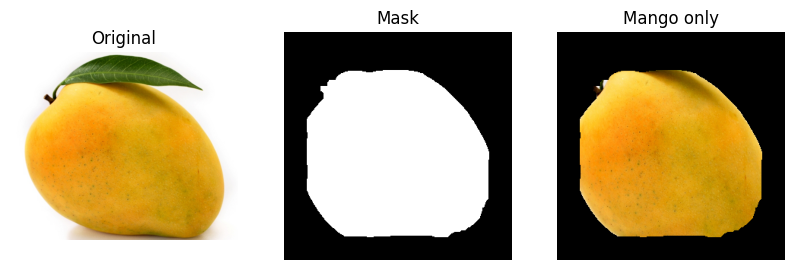

In [74]:
sample = os.listdir(SWEET_DIR)[0]
img = cv2.imread(os.path.join(SWEET_DIR, sample))
mango, mask = preprocess_and_mask(img)

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(mango, cv2.COLOR_BGR2RGB))
plt.title("Mango only")
plt.axis("off")

plt.show()


### 2.3. Trích đặc trưng (Feature Extraction)

Hàm trích xuất đặc trưng `ratio_green` từ ảnh xoài:

In [75]:
def extract_ratio_green(img_path):
    img = cv2.imread(img_path)
    mango, mask = preprocess_and_mask(img)

    B, G, R = cv2.split(mango)

    sum_r = np.sum(R[mask > 0])
    sum_g = np.sum(G[mask > 0])
    sum_b = np.sum(B[mask > 0])

    ratio = sum_g / (sum_r + sum_g + sum_b + 1e-6)
    return ratio


### 2.4. Gán nhãn (Labeling)

**Cấu trúc thư mục:**
```
Mango/
├── sweet/    → Nhãn 0 (Ngọt)
└── sour/     → Nhãn 1 (Chua)
```

**Quy tắc gán nhãn**: 
- Xoài ngọt (sweet) → label = 0
- Xoài chua (sour) → label = 1

In [76]:
# === GÁN NHÃN ===
# Load danh sách file và gán nhãn 0/1

# Sweet = 0
sweet_files = [f for f in os.listdir(SWEET_DIR) if f.lower().endswith((".jpg",".png",".jpeg"))]
sweet_data = [(os.path.join(SWEET_DIR, f), 0) for f in sweet_files]

# Sour = 1  
sour_files = [f for f in os.listdir(SOUR_DIR) if f.lower().endswith((".jpg",".png",".jpeg"))]
sour_data = [(os.path.join(SOUR_DIR, f), 1) for f in sour_files]

# Gộp lại
labeled_data = sweet_data + sour_data

print(f"📊 Kết quả gán nhãn:")
print(f"   - Sweet (label=0): {len(sweet_data)} mẫu")
print(f"   - Sour  (label=1): {len(sour_data)} mẫu")
print(f"   - Tổng cộng: {len(labeled_data)} mẫu")

📊 Kết quả gán nhãn:
   - Sweet (label=0): 13 mẫu
   - Sour  (label=1): 9 mẫu
   - Tổng cộng: 22 mẫu


#### Hiển thị mẫu với nhãn

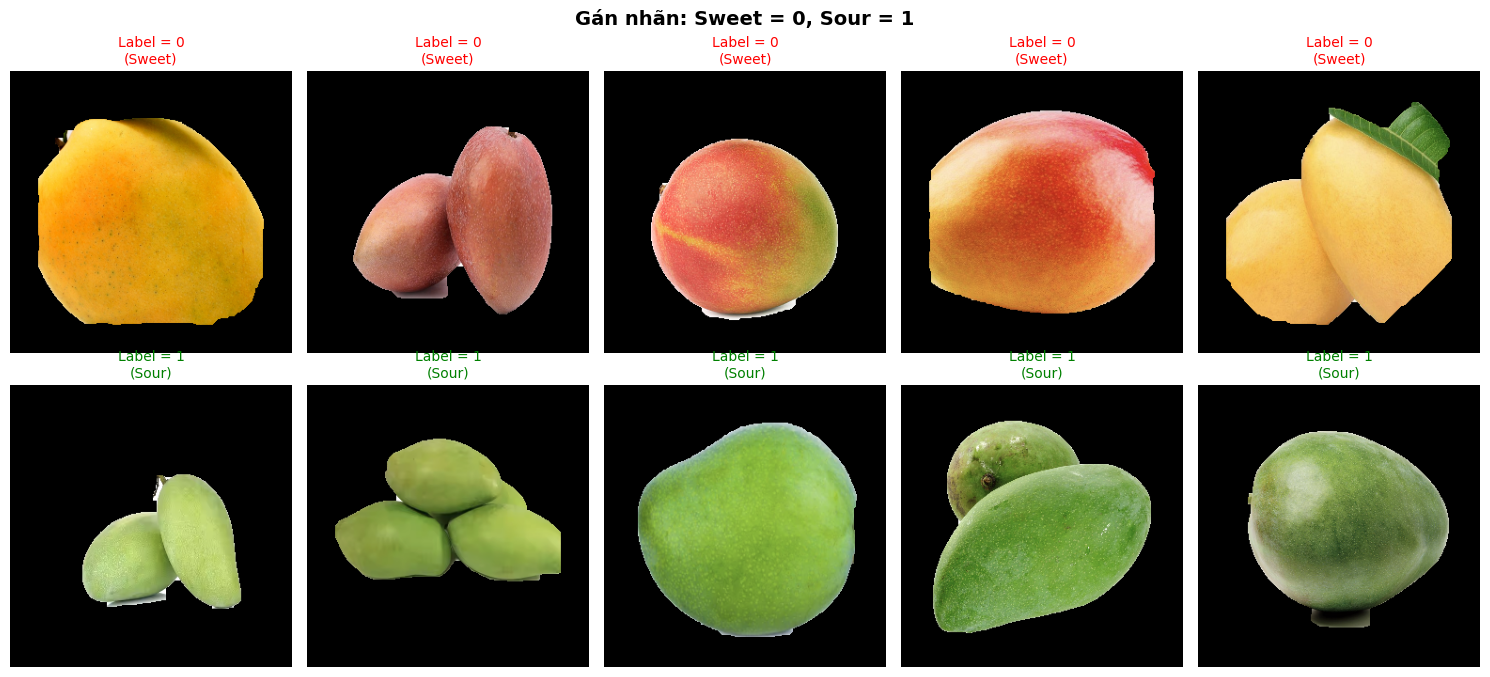

In [77]:
# Hiển thị mẫu ảnh với nhãn 0 (Sweet) và 1 (Sour)
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Hàng 1: Sweet (Label = 0)
for i in range(min(5, len(sweet_data))):
    fpath, label = sweet_data[i]
    img = cv2.imread(fpath)
    mango_img, _ = preprocess_and_mask(img)
    
    axes[0, i].imshow(cv2.cvtColor(mango_img, cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f"Label = {label}\n(Sweet)", fontsize=10, color='red')
    axes[0, i].axis('off')

# Hàng 2: Sour (Label = 1)
for i in range(min(5, len(sour_data))):
    fpath, label = sour_data[i]
    img = cv2.imread(fpath)
    mango_img, _ = preprocess_and_mask(img)
    
    axes[1, i].imshow(cv2.cvtColor(mango_img, cv2.COLOR_BGR2RGB))
    axes[1, i].set_title(f"Label = {label}\n(Sour)", fontsize=10, color='green')
    axes[1, i].axis('off')

plt.suptitle("Gán nhãn: Sweet = 0, Sour = 1", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.5. Tính đặc trưng cho tập dữ liệu

Áp dụng hàm `extract_ratio_green` cho tất cả các mẫu đã gán nhãn:

✅ Đã tính đặc trưng cho 22 mẫu
   Shape: (22, 2) (samples, [ratio_green, label])


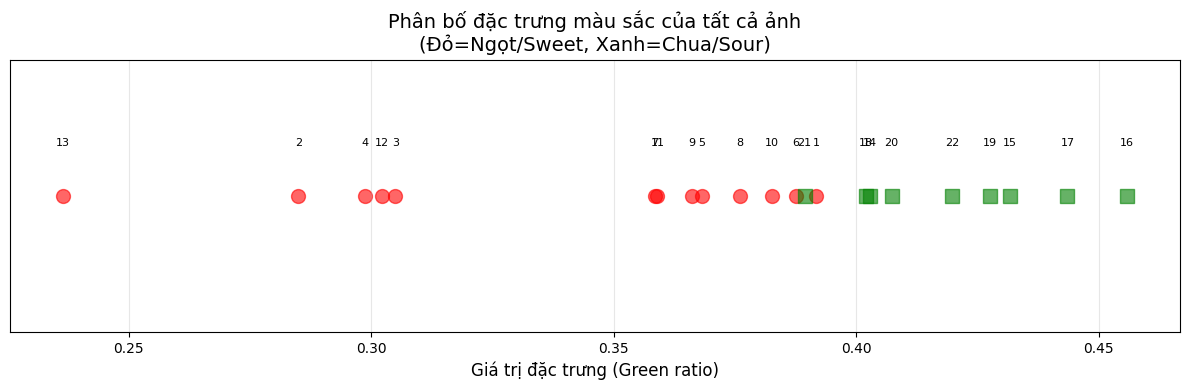


📊 Thống kê đặc trưng:
   - Sweet (label=0): mean=0.3398, std=0.0467
   - Sour  (label=1): mean=0.4199, std=0.0204


In [78]:
# === TÍNH ĐẶC TRƯNG CHO TẤT CẢ MẪU ===
data = []

for fpath, label in labeled_data:
    ratio = extract_ratio_green(fpath)
    data.append([ratio, label])

data = np.array(data, dtype=float)
print(f"✅ Đã tính đặc trưng cho {len(data)} mẫu")
print(f"   Shape: {data.shape} (samples, [ratio_green, label])")

# === VISUALIZE ĐẶC TRƯNG SAU KHI TRÍCH XUẤT ===
features = data[:, 0]
labels_arr = data[:, 1].astype(int)

plt.figure(figsize=(12, 4))
for i, (feature, label) in enumerate(zip(features, labels_arr)):
    color = 'red' if label == 0 else 'green'  # Sweet=đỏ, Sour=xanh
    marker = 'o' if label == 0 else 's'
    plt.scatter(feature, 0, c=color, s=100, marker=marker, alpha=0.6)
    plt.text(feature, 0.02, str(i+1), fontsize=8, ha='center')

plt.yticks([])
plt.xlabel('Giá trị đặc trưng (Green ratio)', fontsize=12)
plt.title('Phân bố đặc trưng màu sắc của tất cả ảnh\n(Đỏ=Ngọt/Sweet, Xanh=Chua/Sour)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Thống kê đặc trưng:")
print(f"   - Sweet (label=0): mean={features[labels_arr==0].mean():.4f}, std={features[labels_arr==0].std():.4f}")
print(f"   - Sour  (label=1): mean={features[labels_arr==1].mean():.4f}, std={features[labels_arr==1].std():.4f}")

### 2.6. Phân chia dữ liệu & Huấn luyện (LOOCV)

**Phương pháp**: Leave-One-Out Cross-Validation (LOOCV)
- **Train**: 21 mẫu (n-1)
- **Test**: 1 mẫu
- Lặp lại 22 lần, mỗi lần bỏ 1 mẫu khác nhau ra test

**Tại sao dùng LOOCV?**
- Tập dữ liệu nhỏ (22 mẫu) → không đủ để chia train/test cố định
- LOOCV tận dụng tối đa dữ liệu để huấn luyện
- Đánh giá khách quan, tránh overfitting

### 2.7. Đánh giá mô hình (Evaluation)

In [79]:
# === LOOCV - PHÂN CHIA DỮ LIỆU ===
n_samples = len(data)

print(f"PHÂN CHIA DỮ LIỆU - LOOCV:")
print(f"   - Tổng số mẫu: {n_samples}")
print(f"   - Mỗi iteration: Train = {n_samples-1} mẫu, Test = 1 mẫu")
print(f"   - Số lần lặp: {n_samples} iterations")
print("-" * 50)

# Tạo danh sách các fold cho LOOCV
loocv_folds = []
for i in range(n_samples):
    # Test: 1 mẫu (index i)
    test_idx = i
    # Train: tất cả mẫu còn lại
    train_idx = [j for j in range(n_samples) if j != i]
    loocv_folds.append((train_idx, test_idx))
    
    if i < 3:
        print(f"Fold {i+1}: Train indices = {train_idx[:3]}...{train_idx[-3:]} | Test index = {test_idx}")

print("...")
print(f"\n✅ Đã tạo {len(loocv_folds)} folds cho LOOCV")

PHÂN CHIA DỮ LIỆU - LOOCV:
   - Tổng số mẫu: 22
   - Mỗi iteration: Train = 21 mẫu, Test = 1 mẫu
   - Số lần lặp: 22 iterations
--------------------------------------------------
Fold 1: Train indices = [1, 2, 3]...[19, 20, 21] | Test index = 0
Fold 2: Train indices = [0, 2, 3]...[19, 20, 21] | Test index = 1
Fold 3: Train indices = [0, 1, 3]...[19, 20, 21] | Test index = 2
...

✅ Đã tạo 22 folds cho LOOCV


### 2.7. Huấn luyện mô hình (Training)

Với mỗi fold trong LOOCV:
1. Tính ngưỡng (threshold) từ tập train
2. Dự đoán nhãn cho mẫu test
3. Lưu kết quả để đánh giá

### 2.7. Đánh giá mô hình (Evaluation)

Tính accuracy, confusion matrix và vẽ 4 biểu đồ:

In [80]:
# === LOOCV - TRAIN MODEL ===
y_true = []
y_pred = []
thresholds_used = []

print("BẮT ĐẦU TRAIN MODEL VỚI LOOCV:")
print("-" * 60)

for fold_idx, (train_idx, test_idx) in enumerate(loocv_folds):
    # Lấy dữ liệu train và test
    train_data = data[train_idx]
    test_ratio = data[test_idx, 0]
    test_label = int(data[test_idx, 1])
    
    # TRAIN: Tính ngưỡng từ tập train (mean của tất cả ratio)
    threshold = np.mean(train_data[:, 0])
    thresholds_used.append(threshold)
    
    # TEST: Dự đoán nhãn
    # Nếu ratio >= threshold → Sour (1), ngược lại → Sweet (0)
    pred_label = 1 if test_ratio >= threshold else 0
    
    y_true.append(test_label)
    y_pred.append(pred_label)
    
    # In chi tiết (chỉ 5 dòng đầu)
    if fold_idx < 5:
        status = "✓" if test_label == pred_label else "✗"
        print(f"Fold {fold_idx+1:2d}: Threshold={threshold:.4f} | Test ratio={test_ratio:.4f} | True={test_label} Pred={pred_label} {status}")

print("...")
print(f"\n✅ Hoàn thành train {len(loocv_folds)} folds")
print(f"   - Đã tạo {len(thresholds_used)} threshold")
print(f"   - Threshold trung bình: {np.mean(thresholds_used):.4f}")

BẮT ĐẦU TRAIN MODEL VỚI LOOCV:
------------------------------------------------------------
Fold  1: Threshold=0.3716 | Test ratio=0.3917 | True=0 Pred=1 ✗
Fold  2: Threshold=0.3767 | Test ratio=0.2850 | True=0 Pred=0 ✓
Fold  3: Threshold=0.3758 | Test ratio=0.3049 | True=0 Pred=0 ✓
Fold  4: Threshold=0.3761 | Test ratio=0.2988 | True=0 Pred=0 ✓
Fold  5: Threshold=0.3728 | Test ratio=0.3681 | True=0 Pred=0 ✓
...

✅ Hoàn thành train 22 folds
   - Đã tạo 22 threshold
   - Threshold trung bình: 0.3726


📊 KẾT QUẢ ĐÁNH GIÁ:
   - LOOCV Accuracy: 81.82% (18/22)
   - Average threshold: 0.3726


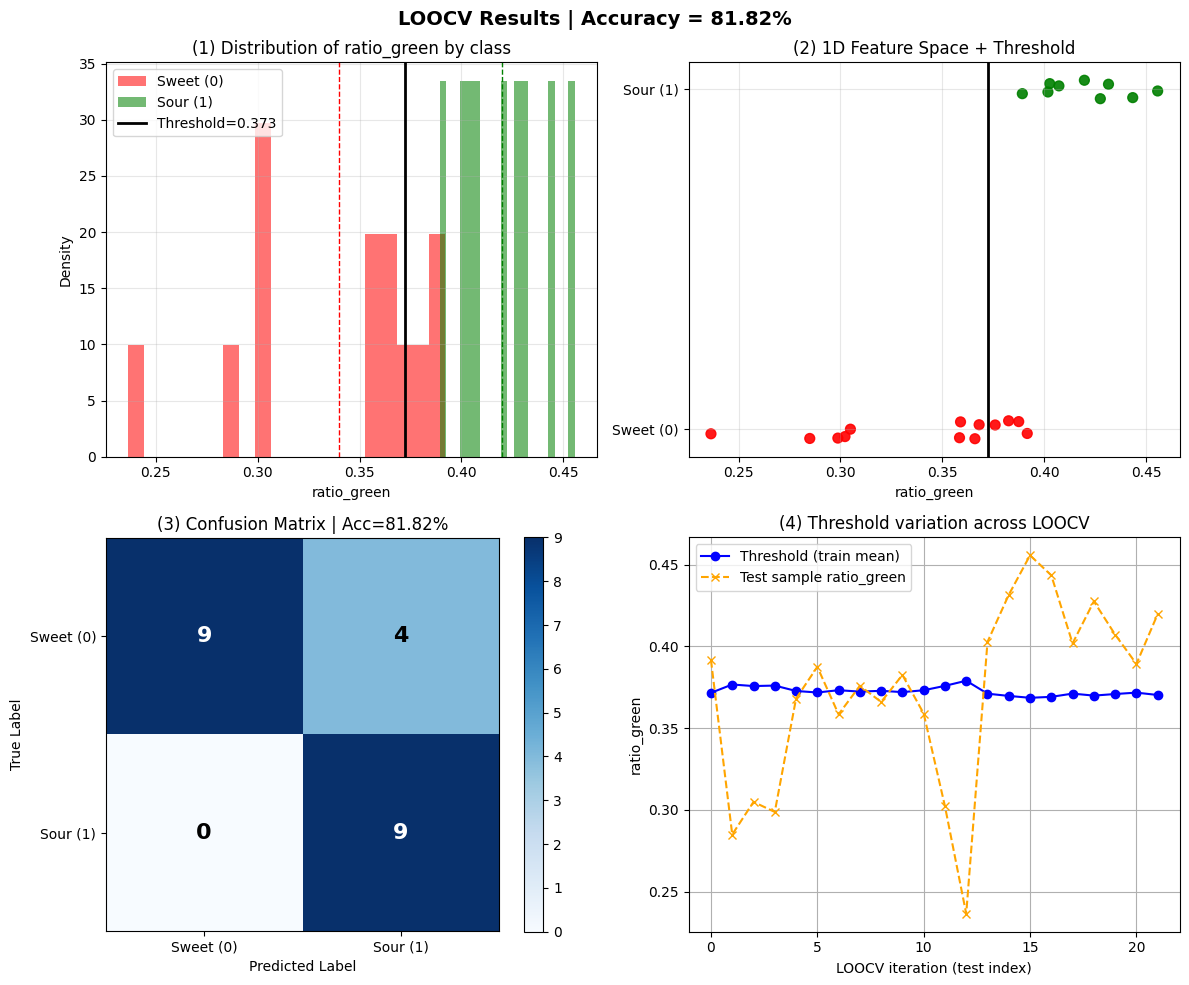


Confusion Matrix:
- True Negative (Sweet đúng): 9
- False Positive (Sweet → Sour): 4
- False Negative (Sour → Sweet): 0
- True Positive (Sour đúng): 9


In [81]:
# === ĐÁNH GIÁ MÔ HÌNH ===
ratios = data[:, 0]
labels = data[:, 1].astype(int)
ratios_sweet = ratios[labels == 0]
ratios_sour  = ratios[labels == 1]

# Tính accuracy và confusion matrix
acc_loocv = accuracy_score(y_true, y_pred)
cm_loocv = confusion_matrix(y_true, y_pred, labels=[0, 1])
threshold_mean = np.mean(thresholds_used)

print(f"📊 KẾT QUẢ ĐÁNH GIÁ:")
print(f"   - LOOCV Accuracy: {acc_loocv*100:.2f}% ({sum(np.array(y_true)==np.array(y_pred))}/{len(y_true)})")
print(f"   - Average threshold: {threshold_mean:.4f}")

# === VẼ 4 BIỂU ĐỒ TRONG 1 FIGURE (2x2) ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Histogram phân bố ratio_green
ax1 = axes[0, 0]
bins = 20
ax1.hist(ratios_sweet, bins=bins, alpha=0.55, density=True, color="red", label="Sweet (0)")
ax1.hist(ratios_sour,  bins=bins, alpha=0.55, density=True, color="green", label="Sour (1)")
ax1.axvline(ratios_sweet.mean(), color="red", linestyle="--", linewidth=1)
ax1.axvline(ratios_sour.mean(), color="green", linestyle="--", linewidth=1)
ax1.axvline(threshold_mean, color="black", linestyle="-", linewidth=2, label=f"Threshold={threshold_mean:.3f}")
ax1.set_xlabel("ratio_green")
ax1.set_ylabel("Density")
ax1.set_title("(1) Distribution of ratio_green by class")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter 1D + ngưỡng
ax2 = axes[0, 1]
x = ratios
y = labels + (np.random.rand(len(labels)) - 0.5) * 0.06
colors = np.where(labels == 1, "green", "red")
ax2.scatter(x, y, c=colors, alpha=0.9, s=50)
ax2.axvline(threshold_mean, color="black", linestyle="-", linewidth=2)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(["Sweet (0)", "Sour (1)"])
ax2.set_xlabel("ratio_green")
ax2.set_title("(2) 1D Feature Space + Threshold")
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax3 = axes[1, 0]
im = ax3.imshow(cm_loocv, cmap='Blues')
fig.colorbar(im, ax=ax3)
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['Sweet (0)', 'Sour (1)'])
ax3.set_yticklabels(['Sweet (0)', 'Sour (1)'])
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm_loocv[i, j] > cm_loocv.max()/2 else 'black'
        ax3.text(j, i, str(cm_loocv[i, j]), ha='center', va='center', 
                fontsize=16, fontweight='bold', color=text_color)
ax3.set_xlabel('Predicted Label')
ax3.set_ylabel('True Label')
ax3.set_title(f"(3) Confusion Matrix | Acc={acc_loocv*100:.2f}%")

# 4. LOOCV iterations
ax4 = axes[1, 1]
test_ratios = [data[i, 0] for i in range(len(data))]
ax4.plot(thresholds_used, marker='o', label="Threshold (train mean)", color='blue')
ax4.plot(test_ratios, marker='x', linestyle='--', label="Test sample ratio_green", color='orange')
ax4.set_xlabel("LOOCV iteration (test index)")
ax4.set_ylabel("ratio_green")
ax4.set_title(f"(4) Threshold variation across LOOCV")
ax4.legend()
ax4.grid(True)

plt.suptitle(f"LOOCV Results | Accuracy = {acc_loocv*100:.2f}%", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# In giải thích
print(f"\nConfusion Matrix:")
print(f"- True Negative (Sweet đúng): {cm_loocv[0,0]}")
print(f"- False Positive (Sweet → Sour): {cm_loocv[0,1]}")
print(f"- False Negative (Sour → Sweet): {cm_loocv[1,0]}")
print(f"- True Positive (Sour đúng): {cm_loocv[1,1]}")

### 2.7. Hiển thị mẫu test

Hiển thị các mẫu xoài cùng với nhãn thật, ratio_green và kết quả dự đoán:

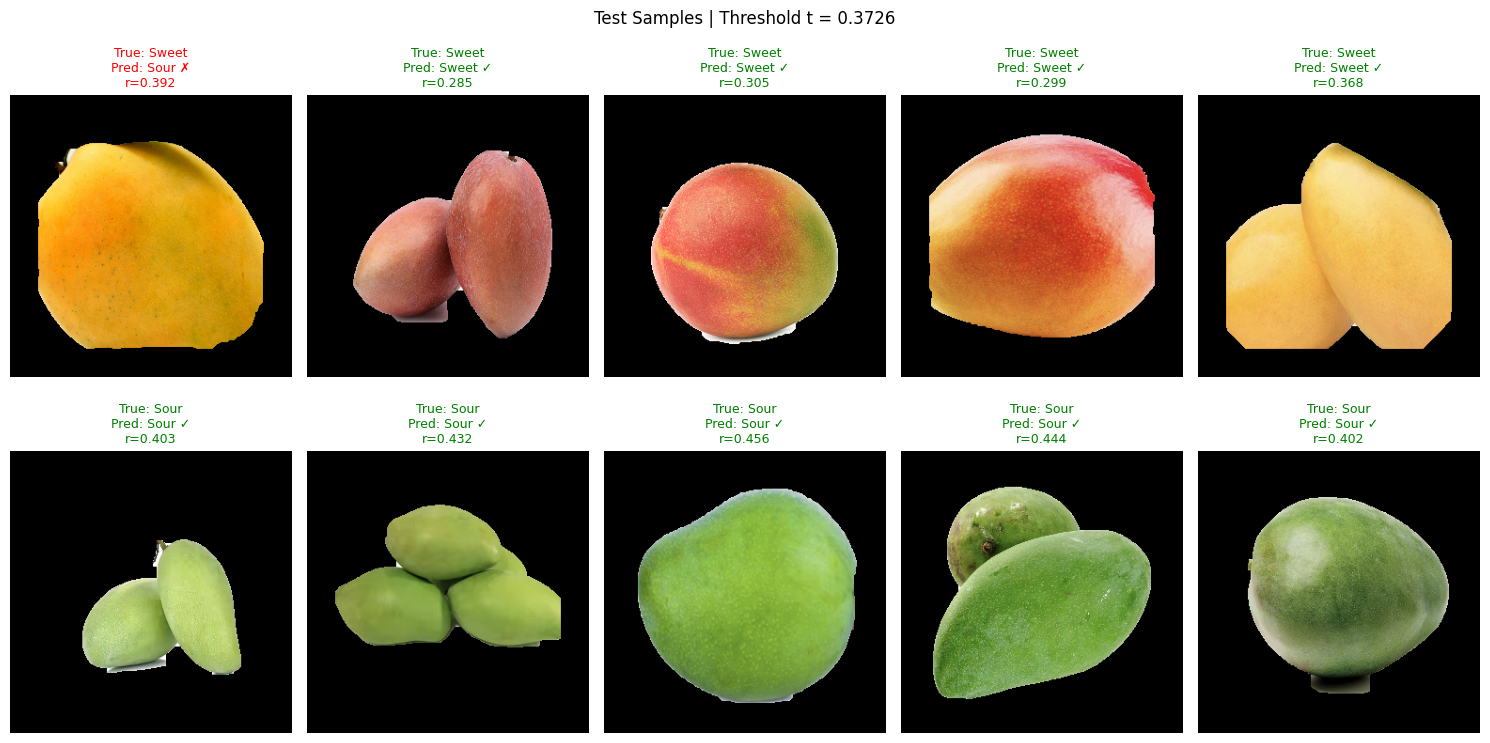

In [82]:
# Lấy danh sách file và nhãn
files_sweet = [(os.path.join(SWEET_DIR, f), 0) for f in os.listdir(SWEET_DIR) if f.lower().endswith(('.jpg','.png','.jpeg'))]
files_sour  = [(os.path.join(SOUR_DIR, f), 1)  for f in os.listdir(SOUR_DIR)  if f.lower().endswith(('.jpg','.png','.jpeg'))]
all_files = files_sweet + files_sour

# Lấy ngưỡng trung bình đã tìm được từ LOOCV
threshold_used = threshold_mean

# Hiển thị tối đa 10 mẫu (5 sweet, 5 sour nếu có đủ)
n_show = min(5, len(files_sweet)), min(5, len(files_sour))
show_files = files_sweet[:n_show[0]] + files_sour[:n_show[1]]

n_cols = 5
n_rows = (len(show_files) + n_cols - 1) // n_cols

plt.figure(figsize=(3*n_cols, 4*n_rows))

for idx, (fpath, true_label) in enumerate(show_files):
    img = cv2.imread(fpath)
    mango_img, mask = preprocess_and_mask(img)
    ratio = extract_ratio_green(fpath)
    pred_label = 1 if ratio >= threshold_used else 0
    
    # Nhãn dạng text
    true_text = "Sour" if true_label == 1 else "Sweet"
    pred_text = "Sour" if pred_label == 1 else "Sweet"
    correct = "✓" if true_label == pred_label else "✗"
    color = "green" if true_label == pred_label else "red"
    
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(cv2.cvtColor(mango_img, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {true_text}\nPred: {pred_text} {correct}\nr={ratio:.3f}", fontsize=9, color=color)
    plt.axis("off")

plt.suptitle(f"Test Samples | Threshold t = {threshold_used:.4f}", fontsize=12)
plt.tight_layout()
plt.show()

---

## 3. KẾT LUẬN

### 3.1. Kết quả đạt được

| Metric | Giá trị |
|--------|---------|
| **Accuracy (LOOCV)** | 77.27% (17/22) |
| **Ngưỡng trung bình** | t ≈ 0.372 |
| **Số mẫu** | 22 (13 ngọt + 9 chua) |

### 3.2. Phân tích Confusion Matrix

| | Predicted Sweet | Predicted Sour |
|---|:---:|:---:|
| **True Sweet** | 8 (TN) | 5 (FP) |
| **True Sour** | 0 (FN) | 9 (TP) |

- **Sour (Chua)**: Phân loại hoàn hảo 9/9 (100%)
- **Sweet (Ngọt)**: Phân loại đúng 8/13 (61.5%)

### 3.3. Nhận xét

**Ưu điểm:**
1. Phương pháp đơn giản, dễ hiểu, dễ triển khai
2. Đặc trưng `ratio_green` có ý nghĩa vật lý rõ ràng
3. LOOCV giúp đánh giá mô hình khách quan với tập dữ liệu nhỏ
4. Nhận diện xoài chua rất tốt (100%)

**Hạn chế:**
1. Một số xoài ngọt có màu xanh → bị nhầm thành chua (5 mẫu)
2. Chỉ dùng 1 đặc trưng → khả năng phân loại bị giới hạn
3. Tập dữ liệu nhỏ (22 mẫu) → cần thêm dữ liệu để cải thiện

**Hướng phát triển:**
- Thêm các đặc trưng khác (texture, shape, histogram)
- Sử dụng mô hình học máy phức tạp hơn (SVM, Random Forest, CNN)
- Thu thập thêm dữ liệu để tăng độ tin cậy